# Práctico Aprendizaje Profundo - Diplodatos 2019
## Redes en escalera avanzadas

Mario Agustín Sgró

## Bibliotecas y definiciones

In [0]:
%%capture
!pip install --upgrade tensorflow-gpu==2.0.0 gensim mlflow scikit-optimize 
!pip install --upgrade grpcio==1.24.3

In [0]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.0.0
True


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import seaborn as sb
from IPython.display import SVG
from gensim import corpora
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from skopt import dump, load

nltk.download(["punkt", "stopwords"]);

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def show_best(res):
    print("Best value: %.4f" % res.fun)
    param_names = {idx: param_name for param_name, idx in search_space_keys.items()}
    best_params = {param_names[i]: param_value for i, param_value in enumerate(res.x)}
    print("Best params:")
    print(best_params)

In [0]:
plt.style.use('default')

import numpy

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.
    output:
        the smoothed signal
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]

    if window == 'flat':
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y = numpy.convolve(w/w.sum(),s,mode='valid')
    return y


def plot_history(history,w_len=3):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, 'b', label='Training acc',alpha=0.4)
    plt.plot(smooth(np.array(acc),window_len=w_len),'b',lw=2)
    plt.plot(val_acc, 'r', label='Validation acc',alpha=0.4)
    plt.plot(smooth(np.array(val_acc),window_len=w_len),'r',lw=2)
    plt.xlabel("Trainig Steps")
    plt.ylabel("Accuracy")
   
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, 'b', label='Training loss',alpha=0.4)
    plt.plot(smooth(np.array(loss),window_len=w_len),'b',lw=2)
    plt.plot(val_loss, 'r', label='Validation loss',alpha=0.4)
    plt.plot(smooth(np.array(val_loss),window_len=w_len),'r',lw=2)
    plt.xlabel("Trainig Steps")
    plt.ylabel("Loss")
    plt.title('Training and validation loss')
    plt.legend()



In [0]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def plot_exploration(res,search_space,host):
  
  A = res.x_iters
  B = res.func_vals
  N = np.array(1.0 - B,dtype=np.float)
  
  M = np.char.replace(A,'Adam','0')
  M = np.char.replace(M,'Nadam','1')
  M = np.array(M,dtype=np.float)
  M = np.append(M,N[:,None],axis=1)
  
  labels = list(search_space.keys())
  labels.append('Accuracy')
  M = pd.DataFrame(data=M,columns=labels)
  
  M["learning_rate"] = M["learning_rate"].apply(lambda x : np.log10(x))
  
  Mmin = pd.DataFrame(np.zeros((1,M.shape[1])),columns=labels)
  Mmax = pd.DataFrame(np.zeros((1,M.shape[1])),columns=labels)
  
  for i,key in enumerate(search_space.keys()):
    if type(search_space_vals[i]) != Categorical:
      Mmin[key] = search_space_vals[i].low
      Mmax[key] = search_space_vals[i].high
  
  Mmin['learning_rate'] = M["learning_rate"].min()
  Mmax['learning_rate'] = M["learning_rate"].max()
  
  Mmin['optimizer'] = 0.0
  Mmax['optimizer'] = 1.0
  
  Mmin['Accuracy'] = M["Accuracy"].min()
  Mmax['Accuracy'] = M["Accuracy"].max()
  
  for col in M.columns:
    M[col] = M[col].apply(lambda x: (x - Mmin[col]) / (Mmax[col] - Mmin[col]))
  
  color = M["Accuracy"].values.astype(np.float)
  nvars = len(labels)
  
  host.spines["top"].set_visible(False)
  host.spines["bottom"].set_visible(False)
  host.xaxis.set_visible(False)
  host.yaxis.set_visible(False)

  host.set_xlim(0, nvars-1)
  host.set_ylim(0-0.01, 1+0.01)
  
  tkw = dict(size=4, width=1.5)
  host.tick_params(axis='x', **tkw)
  
  par = []
  for i,var in enumerate(labels):
    par.append(host.twinx())
    par[i].spines["right"].set_position(("axes", i/(nvars-1)))
    make_patch_spines_invisible(par[i])
    par[i].spines["right"].set_visible(True)
    delta = (Mmax[var].values[0] - Mmin[var].values[0])*0.01
    par[i].set_ylim(Mmin[var].values[0] - delta, Mmax[var].values[0] + delta)
  
    par[i].set_ylabel(var)
    par[i].yaxis.label.set_color('k')
    par[i].tick_params(axis='y', colors='k', **tkw)
  
    if var == 'learning_rate':
      delta = (Mmax[var].values[0] - Mmin[var].values[0])*0.01
      par[i].set_ylim(10.0**(Mmin[var].values[0]-delta),10.0**(Mmax[var].values[0]+delta))
      par[i].semilogy()

    if var == 'optimizer':
      par[i].set_yticks([0.0,1.0],minor=False)
      par[i].set_yticklabels(["Adam","Nadam"])


  N = M.shape[0]
  for i in range(N):
    p1, = host.plot(M.iloc[i].values,c=plt.cm.rainbow_r(color[i]),alpha=0.1)
  
  i = np.argmax(M["Accuracy"].values)
  p1, = host.plot(M.iloc[i],c='m',lw=3.0,alpha=1.0)

## Carga de los datos 

In [0]:
DATA_DIRECTORY = "/content/drive/My Drive/Colab Notebooks/AprendizajeProfundo/PetFinder"

In [0]:
dataset = pd.read_csv(os.path.join(DATA_DIRECTORY, 'train.csv'))

dataset.head(5)

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,Nibble is a 3+ month old ball of cuteness. He ...,2,0
1,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,"Good guard dog, very alert, active, obedience ...",2,3
2,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,This handsome yet cute boy is up for adoption....,2,4
3,2,3,266,0,2,5,6,0,2,1,2,2,2,1,1,0,41326,This is a stray kitten that came to my house. ...,2,5
4,2,12,264,264,1,1,0,0,2,3,2,2,3,1,1,300,41326,anyone within the area of ipoh or taiping who ...,1,6


In [0]:
dataset.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionSpeed,PID
count,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000
mean,1.454734,10.520412,265.469854,74.388868,1.779059,2.230675,3.236912,1.856738,1.860518,1.460971,1.729730,1.566528,1.912115,1.036666,1.584011,20.809960,41345.994613,2.518900,7477.025799
std,0.497970,18.374027,60.121490,123.434010,0.684763,1.743985,2.748595,2.974465,0.547535,0.593843,0.670791,0.701482,0.564041,0.198228,1.488348,78.397243,32.409109,1.176018,4310.921553
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,2.000000,3768.250000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,2.000000,7473.500000
75%,2.000000,12.000000,307.000000,188.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,4.000000,11200.750000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,4.000000,14992.000000


In [0]:
target_col = 'AdoptionSpeed'
nlabels = dataset[target_col].unique().shape[0]
print("Nlabels: %d" % nlabels)

Nlabels: 5


In [0]:
MinState = dataset['State'].min()
dataset['State'] -= MinState

## Preproceso del campo _Description_

- Desechamos _stopwords_ y palabras de un carácter

In [0]:
SW = set(stopwords.words("english"))

def tokenize_description(description):
    #Solo nos quedamos con las palabras que no están en SW y tienen longitud > 1
    return [w.lower() for w in word_tokenize(description, language="english") if((w.lower() not in SW) and (len(w) > 1))] 

# Fill the null values with the empty string to avoid errors with NLTK tokenization
dataset["TokenizedDescription"] = dataset["Description"].fillna(value="").apply(tokenize_description)

In [0]:
dataset["TokenizedDescription"].head(5)

0    [nibble, 3+, month, old, ball, cuteness, energ...
1    [good, guard, dog, alert, active, obedience, w...
2    [handsome, yet, cute, boy, adoption, playful, ...
3          [stray, kitten, came, house, feeding, keep]
4    [anyone, within, area, ipoh, taiping, interest...
Name: TokenizedDescription, dtype: object

### Tamaño de las descripciones

Para estandarizar la longitud de las descripciones tomaremos la longitud correspondiente al tercer cuartil.


In [0]:
pprint(dataset["TokenizedDescription"].apply(len).describe(percentiles=[0.25,0.50,0.75,0.90]))

count    10582.000000
mean        34.813362
std         37.468480
min          0.000000
25%         13.000000
50%         25.000000
75%         44.000000
90%         73.000000
max        592.000000
Name: TokenizedDescription, dtype: float64


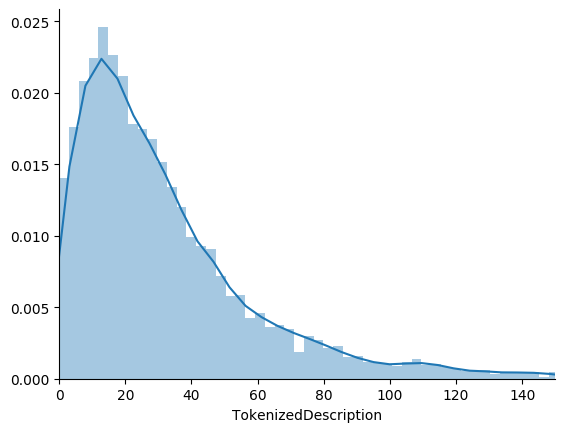

In [0]:
axes = sb.distplot(dataset["TokenizedDescription"].apply(len),bins=200)
sb.despine()

plt.setp(axes, xlim=[0,150]);

Vemos que más del 90% de las secuencias tienen 73 palabras o menos, elegimos ese corte.

In [0]:
MAX_SEQUENCE_LEN = 73

### Vocabulario

In [0]:
vocabulary = corpora.Dictionary(dataset["TokenizedDescription"])
vocabulary.filter_extremes(no_below=1, no_above=1.0, keep_n=10000)

### Word Embeddings (GloVe)

Determinamos los _embeddings_ de las ~10000 palabras más utilizadas en todo el conjunto de las descripciones.

In [0]:
embeddings_index = {}

GLOVE_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/AprendizajeProfundo/'

with open(GLOVE_DIRECTORY+"glove.6B.100d.txt", "r") as fh:
    for line in fh:
        values = line.split()
        word = values[0]
        if word in vocabulary.token2id:  # Only use the embeddings of words in our vocabulary
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

print("Found {} word vectors.".format(len(embeddings_index)))

Found 7874 word vectors.


## Creación de los datasets


Determinamos que variables utilizaremos en nuestra red y sus representaciones

In [0]:
# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Gender', 'Color1','MaturitySize','FurLength','Vaccinated','Health','Dewormed','Sterilized']
}

embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1','Age']
}

numeric_columns = []

### Generador del conjunto de datos

Dada la naturaleza de los datos de texto, y que estos representan una secuencia de datos (que se da luego a una red recurrente o convolucional), en este caso no crearemos los datasets de antemano, sino que los generaremos a medida que el algoritmo de entrenamiento los pida. 

En particular, es porque las secuencias de texto pueden no tener el mismo tamaño (las oraciones tienen diferente cantidad de palabras), pero para que los modelos de redes las acepten, necesitamos rellenarlas (*padding*) de manera que todas tengan el mismo tamaño.


In [0]:
# Pad the datasets to the max value for all the "non sequence" features
padding_shapes = (
    {k: [-1] for k in ["direct_features"] + list(embedded_columns.keys())},
    [-1]
)

# Pad to MAX_SEQUENCE_LEN for sequence features
padding_shapes[0]["description"] = [MAX_SEQUENCE_LEN]

# Pad values are irrelevant for non padded data
padding_values = (
    {k: 0 for k in list(embedded_columns.keys())},
    0
)

# Padding value for direct features should be a float
padding_values[0]["direct_features"] = np.float32(0)

# Padding value for sequential features is the vocabulary length + 1
padding_values[0]["description"] = len(vocabulary) + 1

In [0]:
print("Padding shapes: ")
print(padding_shapes)

Padding shapes: 
({'direct_features': [-1], 'Breed1': [-1], 'Age': [-1], 'description': [73]}, [-1])


In [0]:
print("Padding values: ")
print(padding_values)

Padding values: 
({'Breed1': 0, 'Age': 0, 'direct_features': 0.0, 'description': 10001}, 0)


In [0]:
Scalers = {}

def process_features(df,test_data=False):

    if not test_data:
      for numeric_col in numeric_columns:
        Scalers[numeric_col] = preprocessing.MinMaxScaler().fit(df[numeric_col].values.reshape(-1,1))

    direct_features = []
    instance = {}

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # Create and append numeric columns
    for numeric_col in numeric_columns:
        direct_features.append(Scalers[numeric_col].transform(df[numeric_col].values.reshape(-1,1)))

    # Concatenate all features that don't need further embedding into a single matrix.
    instance['direct_features'] =  np.hstack(direct_features)

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
        instance[embedded_col] = df[embedded_col].values

    # Document to indices for text data, truncated at MAX_SEQUENCE_LEN words
    instance["description"] = [vocabulary.doc2idx(doc,unknown_word_index=len(vocabulary))[:MAX_SEQUENCE_LEN] for doc in df["TokenizedDescription"]]

    instance["description"] = tf.keras.preprocessing.sequence.pad_sequences(instance["description"],
                                                                            padding="post", 
                                                                            maxlen=padding_shapes[0]["description"][0],
                                                                            value=padding_values[0]["description"])
        
    # Convert labels to one-hot encodings
    targets = tf.keras.utils.to_categorical(df[target_col], nlabels)
    return instance, targets

### Datos de entrenamiento y validación

Dividimos la base de datos en conjunto de entrenamiento (70%) y validación (30%). Además, como vamos a utilizar algunos datos que forman secuencias, los lotes (*batches*) de datos deben estar "rellenados" (*padded_batch*). 

Definimos los datos de entrenamiento y de validación

In [0]:
def generate_dataset(df,BATCH_SIZE):

  train_dataset, test_dataset = train_test_split(df, test_size=0.3, shuffle = True)

  X_train, y_train = process_features(train_dataset)
  X_test, y_test = process_features(test_dataset,test_data=True)

  train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  train_dataset = train_dataset.shuffle(buffer_size=len(y_train)).batch(BATCH_SIZE)

  test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(BATCH_SIZE)

  return(train_dataset,test_dataset)


### Matriz de embeddings de palabras

In [0]:
EMBEDDINGS_DIM = 100  # Given by the model (in this case glove.6B.100d)

embedding_matrix = np.zeros((len(vocabulary) + 2, 100))

for widx, word in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[widx] = embedding_vector
    else:
        # Random normal initialization for words without embeddings
        embedding_matrix[widx] = np.random.normal(size=(100,))  

# Random normal initialization for unknown words
embedding_matrix[len(vocabulary)] = np.random.normal(size=(100,))

## Baseline model

### Espacio de Parámetros

In [0]:
from skopt.space import Real, Integer, Categorical

search_space = {
    "batch_size": Integer(500,4000, name="batch_size"),
    "description_features_layer_size": Integer(4, 256, name="description_features_layer_size"),
    "hidden_layer_size": Integer(10, 1000, name="hidden_layer_size"),
    "dropout": Real(low=0.0, high=0.5, prior='uniform', name='dropout'),
    "learning_rate": Real(low=1e-6, high=1.0, prior='log-uniform', name='learning_rate'),
    "optimizer": Categorical(["Adam","Nadam"], name="optimizer")
}

# Unzipping
search_space_keys, search_space_vals = zip(*search_space.items())
search_space_keys = {param_name: idx for idx, param_name in enumerate(search_space_keys)}

def hyperparam_value(param_name, param_list):
    return param_list[search_space_keys[param_name]]

def print_selected_hyperparams(param_values):
    for param_name in search_space_keys:
        print("\t", param_name, hyperparam_value(param_name, param_values))

### Constructor del Modelo

In [0]:
def build_baseline_model(params):
    '''
    Funcion constructura del modelo
    '''
    
    tf.keras.backend.clear_session()

    # Define inputs

    # Add one input and one embedding for each embedded column
    embedding_layers = []
    inputs = []

    for embedded_col, max_value in embedded_columns.items():
        input_layer = tf.keras.layers.Input(shape=(1,), name=embedded_col)
        inputs.append(input_layer)
        embedding_size = int(max_value/4)
        embedding_layers.append(
            tf.squeeze(
                tf.keras.layers.Embedding(
                    input_dim = max_value, 
                    output_dim = embedding_size
                )(input_layer), 
                axis=-2
            )
        )
    
    # Add input for direct feature columns
    direct_features_input = tf.keras.layers.Input(
        shape = (sum(one_hot_columns.values(), len(numeric_columns)),), 
        name = 'direct_features'
    )
    inputs.append(direct_features_input)

    # Word embedding layer
    description_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LEN,), name="description")
    inputs.append(description_input)
    
    word_embeddings_layer = tf.keras.layers.Embedding(
        embedding_matrix.shape[0],
        EMBEDDINGS_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LEN,
        trainable=False,
        name="word_embedding"
    )(description_input)

    DESCRIPTION_FEATURES_LAYER_SIZE = hyperparam_value("description_features_layer_size", params)
    
    description_features = tf.keras.layers.Flatten()(word_embeddings_layer)
    description_features = tf.keras.layers.Dense(
        units = DESCRIPTION_FEATURES_LAYER_SIZE, 
        activation = "relu", 
        name = "description_features")(description_features)

    feature_map = tf.keras.layers.Concatenate(name="feature_map")(
        embedding_layers + [description_features, direct_features_input]
    )

    # Define neural network structure
    HIDDEN_LAYER_SIZE = hyperparam_value("hidden_layer_size", params)
    DROPOUT = hyperparam_value("dropout", params)
    hidden_layer = tf.keras.layers.Dense(HIDDEN_LAYER_SIZE, activation="relu")(feature_map)
    drop_layer = tf.keras.layers.Dropout(DROPOUT)(hidden_layer)
    output_layer = tf.keras.layers.Dense(nlabels, activation="softmax", name="output")(drop_layer)

    # Define optimizer
    learning_rate = hyperparam_value("learning_rate", params)
    if hyperparam_value("optimizer",params) == "Nadam":
      optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    if hyperparam_value("optimizer",params) == "Adam":
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Build
    model = tf.keras.models.Model(inputs=inputs, outputs=[output_layer], name="baseline_model")

    # Compile the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return(model)

In [0]:
def baseline_objective_function(params):

    print_selected_hyperparams(params)

    tf.keras.backend.clear_session()

    # Define datasets
    BATCH_SIZE = hyperparam_value("batch_size", params)
    train_dataset, dev_dataset = generate_dataset(dataset,BATCH_SIZE)

    # Build model with these parameters
    model = build_baseline_model(params)

    # Train
    epochs = 50
    history = model.fit(train_dataset, epochs = epochs, validation_data = dev_dataset, validation_freq = 1, verbose=0)
    
    # Evaluate
    loss, accuracy = model.evaluate(dev_dataset, verbose = 0)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    
    return(1.0 - accuracy)

In [0]:
params = {'batch_size': 4000, 
          'description_features_layer_size': 8, 
          'hidden_layer_size': 128, 
          'dropout': 0.5, 
          'learning_rate': 0.0001, 
          'optimizer': 'Adam'}

train_dataset, dev_dataset = generate_dataset(dataset,params['batch_size'])
model = build_baseline_model(list(params.values()))

In [0]:
model.summary()

Model: "baseline_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description (InputLayer)        [(None, 73)]         0                                            
__________________________________________________________________________________________________
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Age (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 73, 100)      1000200     description[0][0]                
_____________________________________________________________________________________

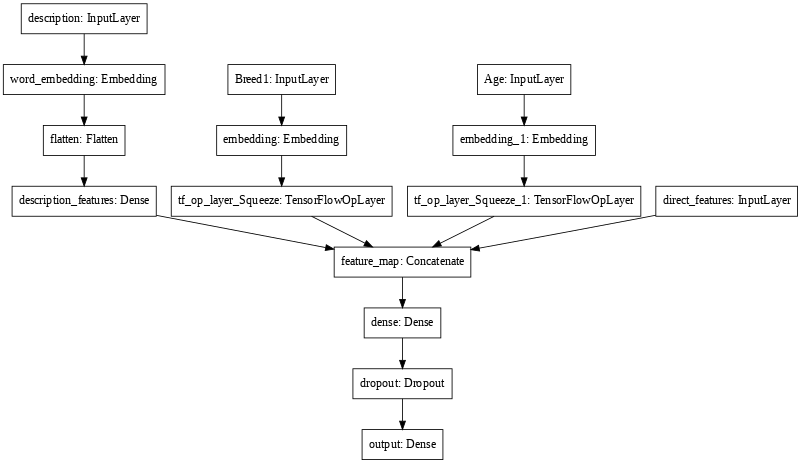

In [0]:
plot_model(model, to_file='baseline_model.png',show_shapes=False,show_layer_names=True,expand_nested=False,dpi=60)

### Entrenando el modelo

Para entrenar el modelo es igual al caso anterior, ya generados el conjunto de datos correspondiente.

In [0]:
 tf.keras.backend.clear_session()

# Train
epochs = 100
history = model.fit(train_dataset,
                    epochs = epochs,
                    validation_data = dev_dataset,
                    validation_freq = 1)

Epoch 1/100
2/2 [==============================] - 2s 1s/step - loss: 1.6303 - accuracy: 0.2338 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 78ms/step - loss: 1.6212 - accuracy: 0.2386 - val_loss: 1.6011 - val_accuracy: 0.2630
Epoch 3/100
2/2 [==============================] - 0s 79ms/step - loss: 1.6167 - accuracy: 0.2413 - val_loss: 1.5935 - val_accuracy: 0.2620
Epoch 4/100
2/2 [==============================] - 0s 83ms/step - loss: 1.6044 - accuracy: 0.2517 - val_loss: 1.5863 - val_accuracy: 0.2639
Epoch 5/100
2/2 [==============================] - 0s 84ms/step - loss: 1.5971 - accuracy: 0.2506 - val_loss: 1.5794 - val_accuracy: 0.2649
Epoch 6/100
2/2 [==============================] - 0s 82ms/step - loss: 1.5922 - accuracy: 0.2593 - val_loss: 1.5730 - val_accuracy: 0.2633
Epoch 7/100
2/2 [==============================] - 0s 82ms/step - loss: 1.5939 - accuracy: 0.2507 - val_loss: 1.5672 - val_accuracy: 0.2592
Epoch 8/100
2/

In [0]:
# Evaluate
loss, accuracy = model.evaluate(dev_dataset, verbose = 1)
print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))

1/1 [==============================] - 0s 40ms/step - loss: 1.4283 - accuracy: 0.3518
*** Test loss: 1.4283078908920288 - accuracy: 0.351811021566391


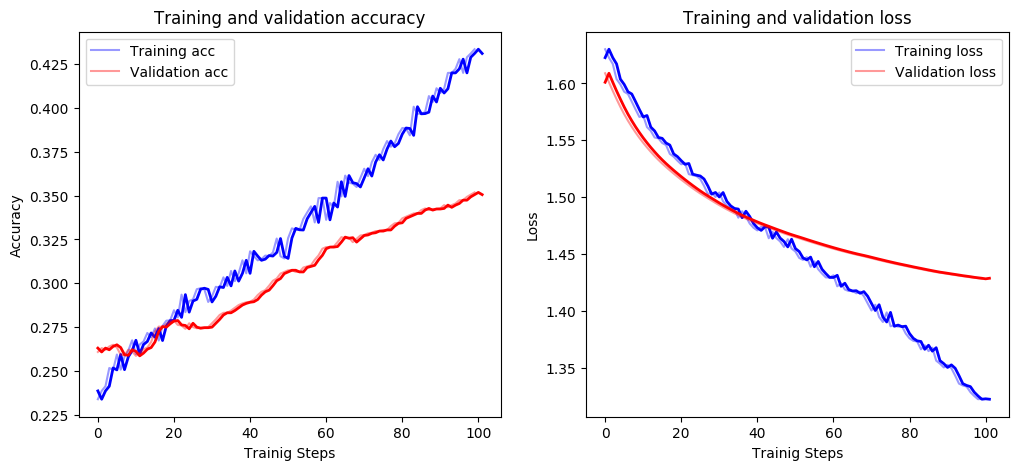

In [0]:
plot_history(history)

### Buscando mejores parámetros

In [0]:
iterations = 200
exploration_result = gp_minimize(
    baseline_objective_function, search_space_vals,
    random_state = 21, verbose = 0, n_calls = iterations)

In [0]:
dump(exploration_result, '/content/drive/My Drive/Colab Notebooks/AprendizajeProfundo/Exploration_Results_BaseLine.pkl')

In [0]:
res = load('/content/drive/My Drive/Colab Notebooks/AprendizajeProfundo/Exploration_Results_BaseLine.pkl')
exploration_result = res

In [0]:
show_best(exploration_result)

Best value: 0.6173
Best params:
{'batch_size': 3225, 'description_features_layer_size': 4, 'hidden_layer_size': 1000, 'dropout': 0.5, 'learning_rate': 0.00012165169717345854, 'optimizer': 'Adam'}


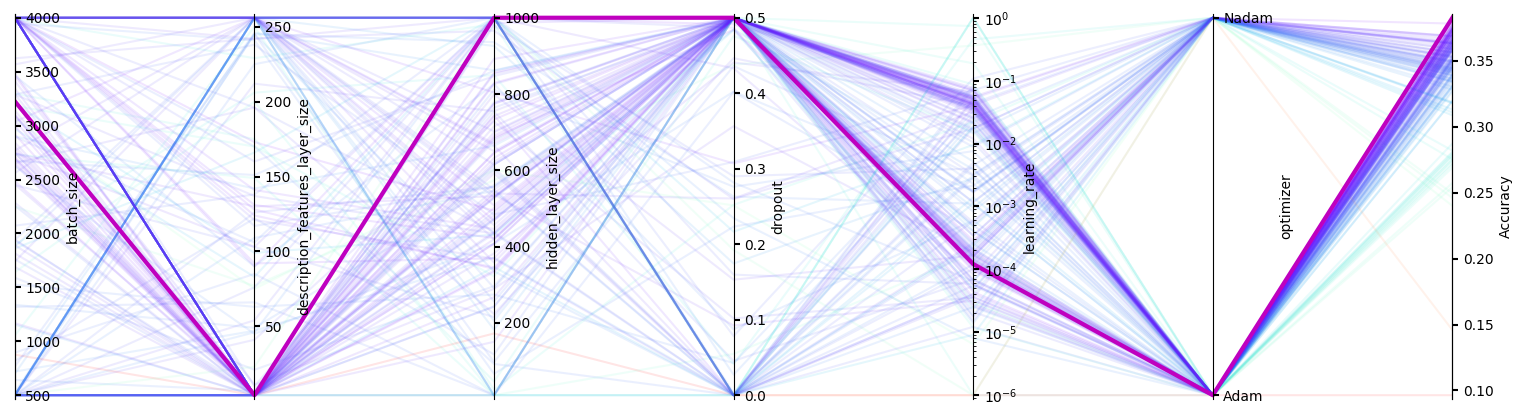

In [0]:
fig, host = plt.subplots(figsize=(23,5))
fig.subplots_adjust(right=0.75)
plot_exploration(res,search_space,host)
plt.show()

In [0]:
best_params = exploration_result.x

train_dataset, dev_dataset = generate_dataset(dataset,hyperparam_value("batch_size", best_params))
model = build_baseline_model(best_params)

In [0]:
 tf.keras.backend.clear_session()

# Train
epochs = 30
history = model.fit(train_dataset,
                    epochs = epochs,
                    validation_data = dev_dataset,
                    validation_freq = 1,
                    verbose=0)

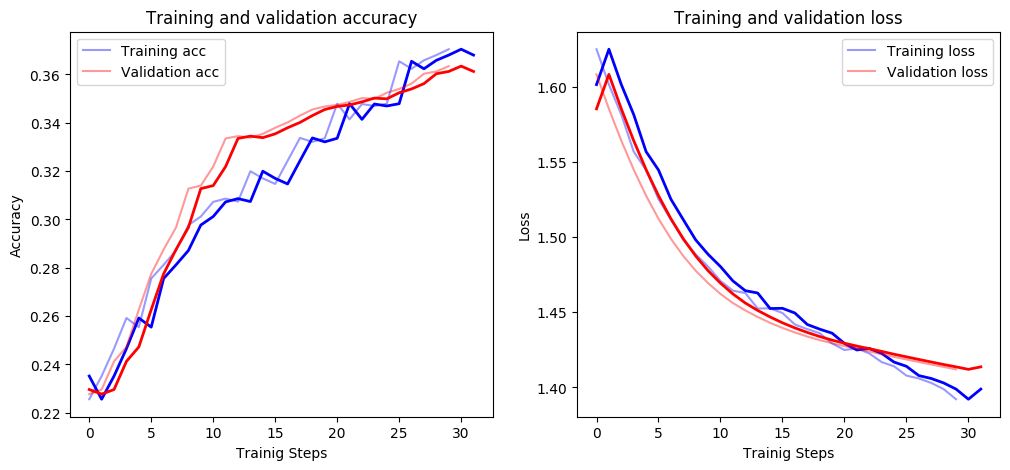

In [0]:
plot_history(history)

## Modelo con redes escalonadas

Definimos una función que construye el modelo según los parámetros dados

### Espacio de Parámetros

In [0]:
search_space = {
    "batch_size": Integer(500,4000, name="batch_size"),
    "description_features_layer_size": Integer(4, 256, name="description_features_layer_size"),
    "description_features_dropout1": Real(low=0.0, high=0.5, prior='uniform', name='description_features_dropout1'),
    "description_features_dropout2": Real(low=0.0, high=0.5, prior='uniform', name='description_features_dropout2'),
    "hidden_layer_size": Integer(1000, 10000, name="hidden_layer_size"),
    "dropout": Real(low=0.0, high=0.5, prior='uniform', name='dropout'),
    "learning_rate": Real(low=1e-6, high=1.0, prior='log-uniform', name='learning_rate'),
    "optimizer": Categorical(["Adam","Nadam"], name="optimizer")
}

# Unzipping
search_space_keys, search_space_vals = zip(*search_space.items())
search_space_keys = {param_name: idx for idx, param_name in enumerate(search_space_keys)}

def hyperparam_value(param_name, param_list):
    return param_list[search_space_keys[param_name]]

def print_selected_hyperparams(param_values):
    for param_name in search_space_keys:
        print("\t", param_name, hyperparam_value(param_name, param_values))

### Constructor del Modelo

In [0]:
def build_cnn_model(params):
    '''
    Funcion constructura del modelo
    '''
    
    #Definimos los inputs del modelo
    # Add one input and one embedding for each embedded column
    embedding_layers = []
    inputs = []

    for embedded_col, max_value in embedded_columns.items():

        input_layer = tf.keras.layers.Input(shape = (1,), name = embedded_col)
        inputs.append(input_layer)

        embedding_size = int(max_value/4)
        embedding_layers.append(
            tf.squeeze(
                tf.keras.layers.Embedding(
                    input_dim  = max_value, 
                    output_dim = embedding_size
                )(input_layer), 
                axis = -2
            )
        )
    
    direct_features_input = tf.keras.layers.Input(
        shape = (sum(one_hot_columns.values(), len(numeric_columns)),), 
        name = 'direct_features'
    )
    inputs.append(direct_features_input)
    
    # Word embedding layer
    description_input = tf.keras.layers.Input(shape = (MAX_SEQUENCE_LEN,), name = "description")
    inputs.append(description_input)
    
    word_embeddings_layer = tf.keras.layers.Embedding(
        embedding_matrix.shape[0],
        EMBEDDINGS_DIM,
        weights = [embedding_matrix],
        input_length = MAX_SEQUENCE_LEN,
        trainable = False,
        name = "word_embedding"
    )(description_input)

    #Definimos la red convolucional para los embeddings de las descripciones
    DESCRIPTION_FEATURES_LAYER_SIZE = hyperparam_value("description_features_layer_size", params)
    DESCRIPTION_FEATURES_DROPOUT1 = hyperparam_value("description_features_dropout1", params)
    DESCRIPTION_FEATURES_DROPOUT2 = hyperparam_value("description_features_dropout2", params)

    convs = []
    filter_sizes = [2,3,4,5,6]
    for filter_size in filter_sizes:
        l_conv = tf.keras.layers.Conv1D(filters = 200, kernel_size = filter_size, activation = 'relu')(word_embeddings_layer)
        l_pool = tf.keras.layers.GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)

    l_merge = tf.keras.layers.concatenate(convs, axis=1)
    x = tf.keras.layers.Dropout(DESCRIPTION_FEATURES_DROPOUT1)(l_merge)  
    x = tf.keras.layers.Dense(DESCRIPTION_FEATURES_LAYER_SIZE, activation='relu')(x)
    description_features = tf.keras.layers.Dropout(DESCRIPTION_FEATURES_DROPOUT2,name="description_features")(x)

    feature_map = tf.keras.layers.Concatenate(name="feature_map")(
        embedding_layers + [description_features, direct_features_input]
    )

    #Definimos la estructura de la red
    DROPOUT = hyperparam_value("dropout", params)
    HIDDEN_LAYER_SIZE = hyperparam_value("hidden_layer_size", params)

    hidden_layer = tf.keras.layers.Dense(HIDDEN_LAYER_SIZE, activation="relu")(feature_map)
    drop_layer = tf.keras.layers.Dropout(DROPOUT)(hidden_layer)
    output_layer = tf.keras.layers.Dense(nlabels, activation="softmax", name="output")(drop_layer)

    #Definimos el optimizador
    learning_rate = hyperparam_value("learning_rate", params)
    if hyperparam_value("optimizer",params) == "Nadam":
      optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    if hyperparam_value("optimizer",params) == "Adam":
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Construimos el modelo
    model = tf.keras.models.Model(inputs=inputs, outputs=[output_layer], name="cnn_model")

    #Compilamos el modelo
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer = optimizer,
                  metrics=['accuracy'])
    
    return(model)

In [0]:
def objective_function(params):

    print_selected_hyperparams(params)

    tf.keras.backend.clear_session()

    BATCH_SIZE = hyperparam_value("batch_size", params)

    train_dataset, dev_dataset = generate_dataset(dataset,BATCH_SIZE)

    model = build_cnn_model(params)

    # Train
    epochs = 15
    history = model.fit(train_dataset, epochs = epochs, validation_data = dev_dataset, validation_freq = 1)
    
    # Evaluate
    loss, accuracy = model.evaluate(dev_dataset, verbose = 0)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    
    return(1.0 - accuracy)

In [0]:
params = {'batch_size': 4000, 
          'description_features_layer_size': 512, 
          'description_features_dropout1': 0.2, 
          'description_features_dropout2': 0.2, 
          'hidden_layer_size': 1000, 
          'dropout': 0.5, 
          'learning_rate': 0.001, 
          'optimizer': 'Adam'}

train_dataset, dev_dataset = generate_dataset(dataset,params['batch_size'])
model = build_cnn_model(list(params.values()))

In [0]:
model.summary()

Model: "cnn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description (InputLayer)        [(None, 73)]         0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 73, 100)      1000200     description[0][0]                
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 72, 200)      40200       word_embedding[0][0]             
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 71, 200)      60200       word_embedding[0][0]             
__________________________________________________________________________________________

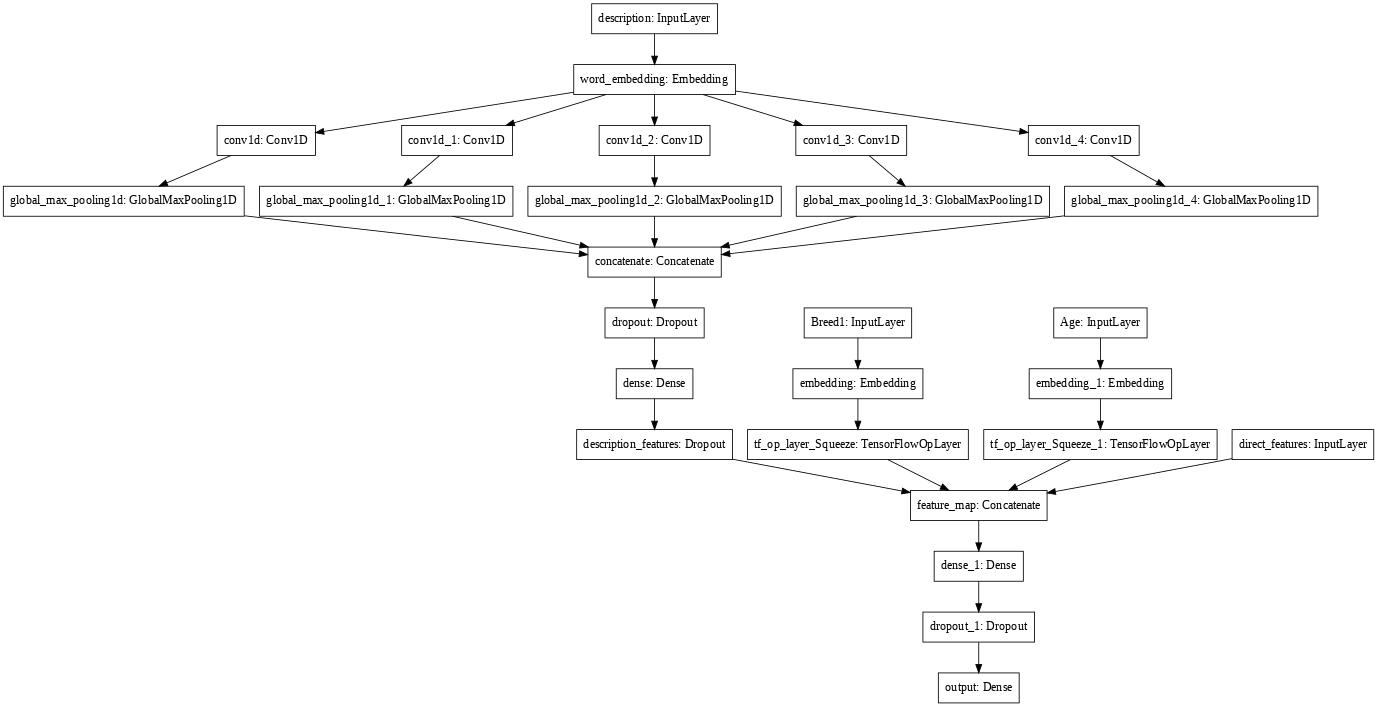

In [0]:
plot_model(model, to_file='cnn_model.png',show_shapes=False,show_layer_names=True,expand_nested=False,dpi=60)

### Entrenando el modelo

Para entrenar el modelo es igual al caso anterior, ya generados el conjunto de datos correspondiente.

In [0]:
 tf.keras.backend.clear_session()

# Train
epochs = 20
history = model.fit(train_dataset,
                    epochs = epochs,
                    validation_data = dev_dataset,
                    validation_freq = 1,
                    verbose=0)

In [0]:
# Evaluate
loss, accuracy = model.evaluate(dev_dataset, verbose = 1)
print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))

1/1 [==============================] - 0s 79ms/step - loss: 1.3763 - accuracy: 0.3717
*** Test loss: 1.3762727975845337 - accuracy: 0.37165355682373047


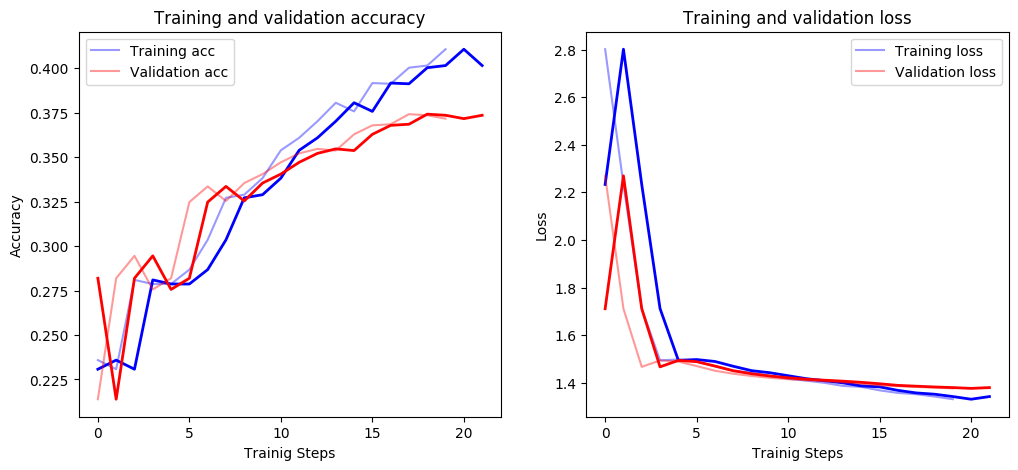

In [0]:
plot_history(history)


### Optimizando el modelo

In [0]:
iterations = 200

exploration_result = gp_minimize(objective_function,
                                 search_space_vals,
                                 random_state = 47,
                                 verbose = 1,
                                 n_calls = iterations)

In [0]:
#dump(exploration_result, '/content/drive/My Drive/Colab Notebooks/AprendizajeProfundo/Exploration_Results_CNN.pkl')

In [0]:
res = load('/content/drive/My Drive/Colab Notebooks/AprendizajeProfundo/Exploration_Results_CNN.pkl')
exploration_result = res

In [0]:
show_best(exploration_result)

Best value: 0.5956
Best params:
{'batch_size': 2006, 'description_features_layer_size': 256, 'description_features_dropout1': 0.0, 'description_features_dropout2': 0.5, 'hidden_layer_size': 10000, 'dropout': 0.5, 'learning_rate': 0.0005562695423941707, 'optimizer': 'Adam'}


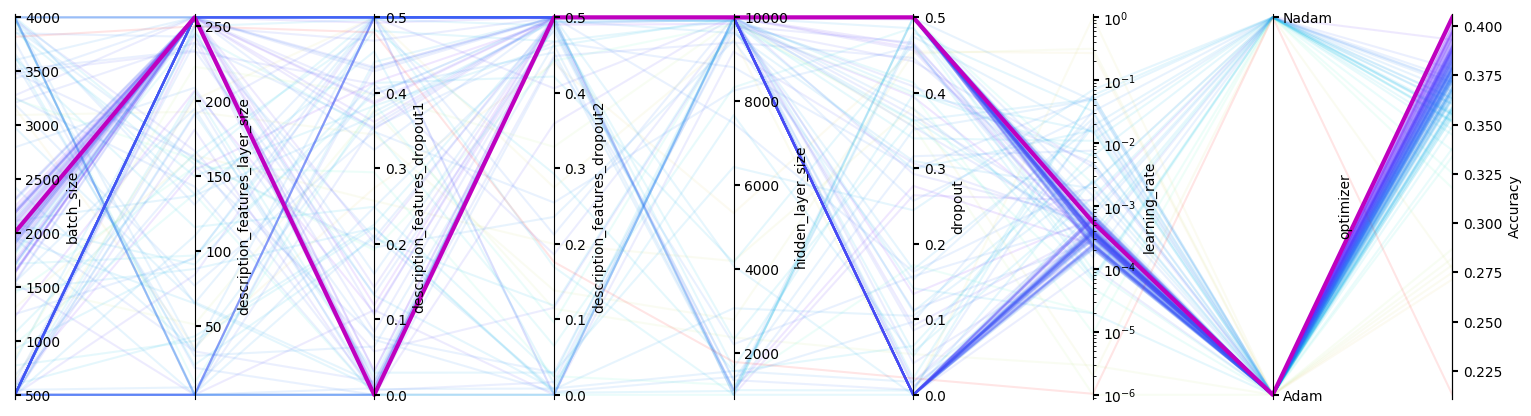

In [0]:
fig, host = plt.subplots(figsize=(23,5))
fig.subplots_adjust(right=0.75)
plot_exploration(res,search_space,host)
plt.show()

In [0]:
best_params = exploration_result.x

train_dataset, dev_dataset = generate_dataset(dataset,hyperparam_value("batch_size", best_params))
model = build_cnn_model(best_params)

In [0]:
 tf.keras.backend.clear_session()

# Train
epochs = 15
history = model.fit(train_dataset,
                    epochs = epochs,
                    validation_data = dev_dataset,
                    validation_freq = 1,
                    verbose=0)

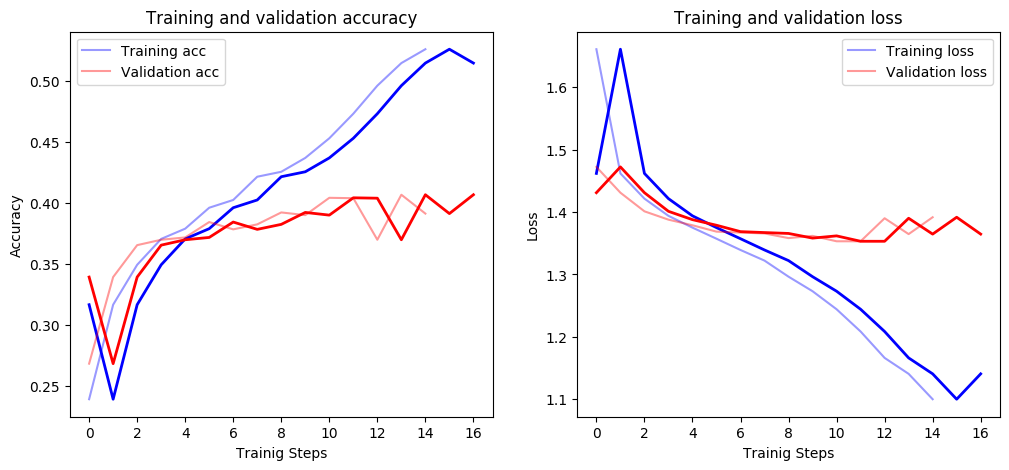

In [0]:
plot_history(history)

## Modelo con Simple NN

Definimos una función que construye el modelo según los parámetros dados

### Espacio de Parámetros

In [0]:
search_space = {
    "batch_size": Integer(500,4000, name="batch_size"),
    "description_features_layer_size": Integer(4, 256, name="description_features_layer_size"),
    "description_features_dropout1": Real(low=0.0, high=0.5, prior='uniform', name='description_features_dropout1'),
    "description_features_dropout2": Real(low=0.0, high=0.5, prior='uniform', name='description_features_dropout2'),
    "hidden_layer_size": Integer(1000, 10000, name="hidden_layer_size"),
    "dropout": Real(low=0.0, high=0.5, prior='uniform', name='dropout'),
    "learning_rate": Real(low=1e-6, high=1.0, prior='log-uniform', name='learning_rate'),
    "optimizer": Categorical(["Adam","Nadam"], name="optimizer")
}

# Unzipping
search_space_keys, search_space_vals = zip(*search_space.items())
search_space_keys = {param_name: idx for idx, param_name in enumerate(search_space_keys)}

def hyperparam_value(param_name, param_list):
    return param_list[search_space_keys[param_name]]

def print_selected_hyperparams(param_values):
    for param_name in search_space_keys:
        print("\t", param_name, hyperparam_value(param_name, param_values))

In [0]:
def build_RNN_model(params):
    '''
    Funcion constructura del modelo
    '''
    
    #Definimos los inputs del modelo
    # Add one input and one embedding for each embedded column
    embedding_layers = []
    inputs = []

    for embedded_col, max_value in embedded_columns.items():

        input_layer = tf.keras.layers.Input(shape = (1,), name = embedded_col)
        inputs.append(input_layer)

        embedding_size = int(max_value/4)
        embedding_layers.append(
            tf.squeeze(
                tf.keras.layers.Embedding(
                    input_dim  = max_value, 
                    output_dim = embedding_size
                )(input_layer), 
                axis = -2
            )
        )
    
    direct_features_input = tf.keras.layers.Input(
        shape = (sum(one_hot_columns.values(), len(numeric_columns)),), 
        name = 'direct_features'
    )
    inputs.append(direct_features_input)
    
    # Word embedding layer
    description_input = tf.keras.layers.Input(shape = (MAX_SEQUENCE_LEN,), name = "description")
    inputs.append(description_input)
    
    word_embeddings_layer = tf.keras.layers.Embedding(
        embedding_matrix.shape[0],
        EMBEDDINGS_DIM,
        weights = [embedding_matrix],
        input_length = MAX_SEQUENCE_LEN,
        trainable = False,
        name = "word_embedding"
    )(description_input)

    #Definimos la red convolucional para los embeddings de las descripciones
    DESCRIPTION_FEATURES_LAYER_SIZE = hyperparam_value("description_features_layer_size", params)
    DESCRIPTION_FEATURES_DROPOUT1 = hyperparam_value("description_features_dropout1", params)
    DESCRIPTION_FEATURES_DROPOUT2 = hyperparam_value("description_features_dropout2", params)

    lstm_layer = tf.keras.layers.LSTM(128)(word_embeddings_layer)

    x = tf.keras.layers.Dropout(DESCRIPTION_FEATURES_DROPOUT1)(lstm_layer)  
    x = tf.keras.layers.Dense(DESCRIPTION_FEATURES_LAYER_SIZE, activation='relu')(x)
    description_features = tf.keras.layers.Dropout(DESCRIPTION_FEATURES_DROPOUT2,name="description_features")(x)

    feature_map = tf.keras.layers.Concatenate(name="feature_map")(
        embedding_layers + [description_features, direct_features_input]
    )

    #Definimos la estructura de la red
    DROPOUT = hyperparam_value("dropout", params)
    HIDDEN_LAYER_SIZE = hyperparam_value("hidden_layer_size", params)

    hidden_layer = tf.keras.layers.Dense(HIDDEN_LAYER_SIZE, activation="relu")(feature_map)
    drop_layer = tf.keras.layers.Dropout(DROPOUT)(hidden_layer)
    output_layer = tf.keras.layers.Dense(nlabels, activation="softmax", name="output")(drop_layer)

    #Definimos el optimizador
    learning_rate = hyperparam_value("learning_rate", params)
    if hyperparam_value("optimizer",params) == "Nadam":
      optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    if hyperparam_value("optimizer",params) == "Adam":
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Construimos el modelo
    model = tf.keras.models.Model(inputs=inputs, outputs=[output_layer], name="RNN_model")

    #Compilamos el modelo
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return(model)

In [0]:
def objective_function(params):

    print_selected_hyperparams(params)

    tf.keras.backend.clear_session()

    BATCH_SIZE = hyperparam_value("batch_size", params)

    train_dataset, dev_dataset = generate_dataset(dataset,BATCH_SIZE)

    model = build_RNN_model(params)

    # Train
    epochs = 15
    history = model.fit(train_dataset, epochs = epochs, validation_data = dev_dataset, validation_freq = 1)
    
    # Evaluate
    loss, accuracy = model.evaluate(dev_dataset, verbose = 0)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    
    return(1.0 - accuracy)

In [0]:
params = {'batch_size': 2000, 
          'description_features_layer_size': 256, 
          'description_features_dropout1': 0.0, 
          'description_features_dropout2': 0.5, 
          'hidden_layer_size': 1000, 
          'dropout': 0.5, 
          'learning_rate': 9.0E-4, 
          'optimizer': 'Adam'}

train_dataset, dev_dataset = generate_dataset(dataset,1000)
model = build_RNN_model(list(params.values()))

In [0]:
model.summary()

Model: "RNN_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description (InputLayer)        [(None, 73)]         0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 73, 100)      1000200     description[0][0]                
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          117248      word_embedding[0][0]             
__________________________________________________________________________________________________
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________

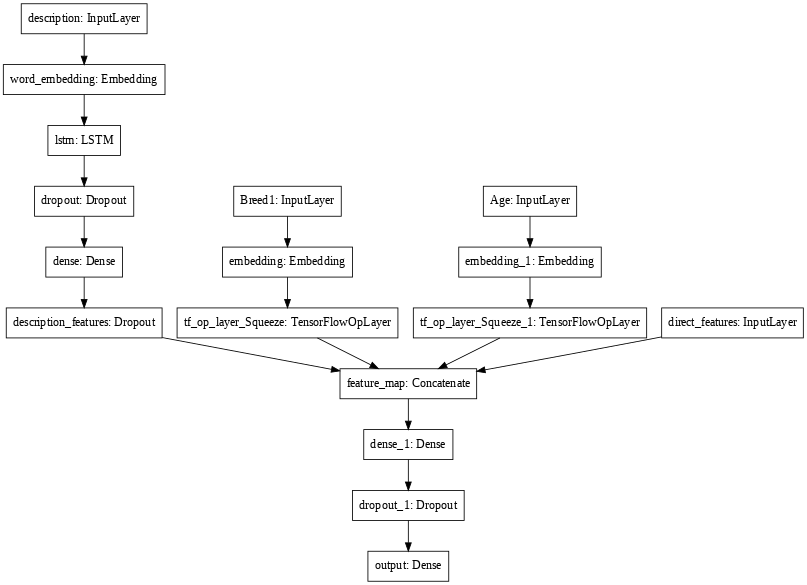

In [0]:
plot_model(model, to_file='rnn_model.png',show_shapes=False,show_layer_names=True,expand_nested=False,dpi=60)

### Entrenando el modelo

Para entrenar el modelo es igual al caso anterior, ya generados el conjunto de datos correspondiente.

In [0]:
 tf.keras.backend.clear_session()

# Train
epochs = 30
history = model.fit(train_dataset,
                    epochs = epochs,
                    validation_data = dev_dataset,
                    validation_freq = 1,
                    verbose=0)

In [0]:
# Evaluate
loss, accuracy = model.evaluate(dev_dataset, verbose = 1)
print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))

4/4 [==============================] - 0s 18ms/step - loss: 1.8635 - accuracy: 0.3515
*** Test loss: 1.8635147213935852 - accuracy: 0.3514960706233978


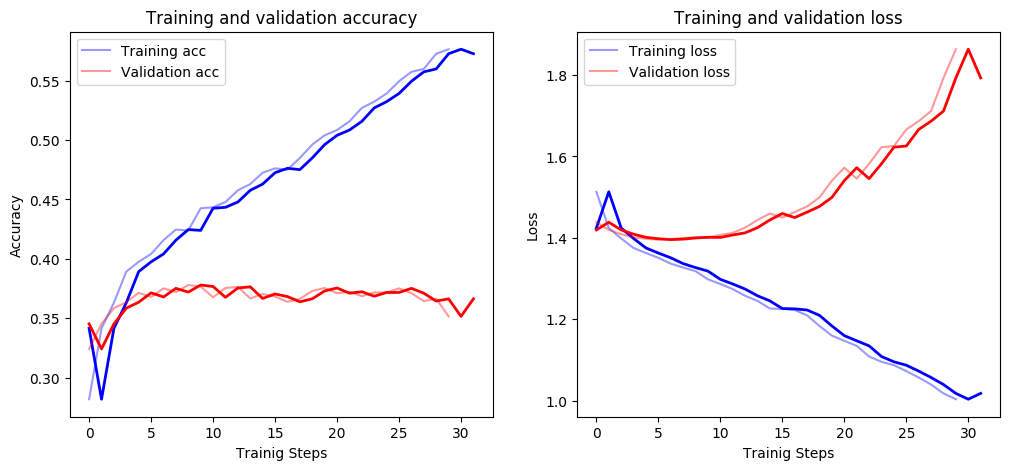

In [0]:
plot_history(history)


### Optimizando el modelo

In [0]:
iterations = 200

exploration_result = gp_minimize(objective_function,
                                 search_space_vals,
                                 random_state = 47,
                                 verbose = 1,
                                 n_calls = iterations)

In [0]:
#dump(exploration_result, '/content/drive/My Drive/Colab Notebooks/AprendizajeProfundo/Exploration_Results_RNN.pkl')

In [0]:
res = load('/content/drive/My Drive/Colab Notebooks/AprendizajeProfundo/Exploration_Results_RNN.pkl')
exploration_result = res

In [0]:
show_best(exploration_result)

Best value: 0.6028
Best params:
{'batch_size': 500, 'description_features_layer_size': 4, 'description_features_dropout1': 0.5, 'description_features_dropout2': 0.5, 'hidden_layer_size': 10000, 'dropout': 0.02376663393246057, 'learning_rate': 0.00013451014355483958, 'optimizer': 'Nadam'}


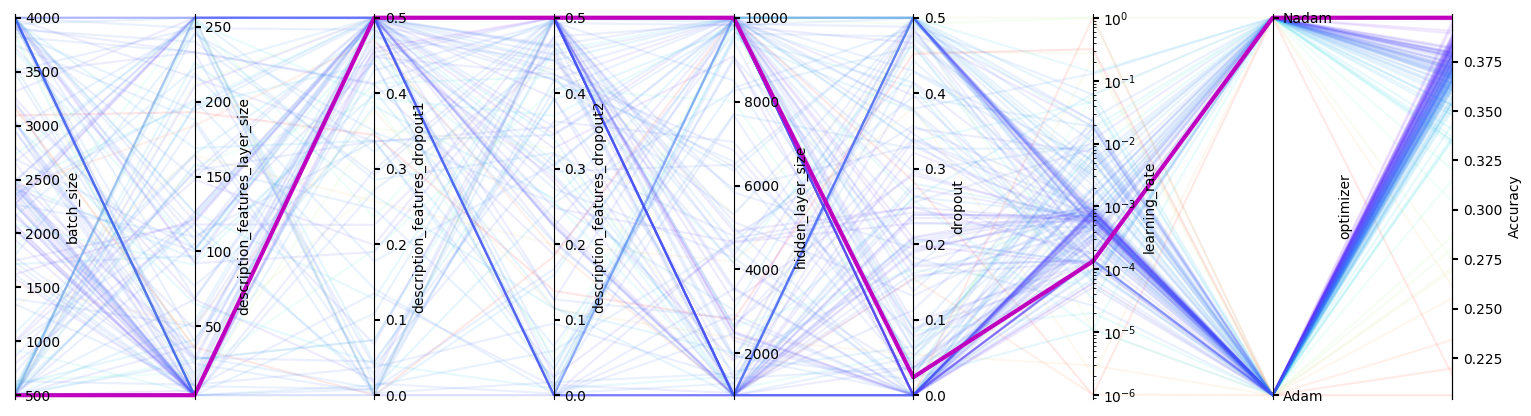

In [0]:
fig, host = plt.subplots(figsize=(23,5))
fig.subplots_adjust(right=0.75)
plot_exploration(res,search_space,host)
plt.show()

In [0]:
best_params = exploration_result.x

train_dataset, dev_dataset = generate_dataset(dataset,hyperparam_value("batch_size", best_params))
model = build_RNN_model(best_params)

In [0]:
 tf.keras.backend.clear_session()

# Train
epochs = 30
history = model.fit(train_dataset,
                    epochs = epochs,
                    validation_data = dev_dataset,
                    validation_freq = 1)

Epoch 1/30
15/15 [==============================] - 4s 293ms/step - loss: 1.5245 - accuracy: 0.3209 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
15/15 [==============================] - 0s 31ms/step - loss: 1.4355 - accuracy: 0.3452 - val_loss: 1.4247 - val_accuracy: 0.3446
Epoch 3/30
15/15 [==============================] - 0s 31ms/step - loss: 1.4044 - accuracy: 0.3632 - val_loss: 1.4097 - val_accuracy: 0.3600
Epoch 4/30
15/15 [==============================] - 0s 32ms/step - loss: 1.3861 - accuracy: 0.3791 - val_loss: 1.4007 - val_accuracy: 0.3694
Epoch 5/30
15/15 [==============================] - 0s 31ms/step - loss: 1.3709 - accuracy: 0.3857 - val_loss: 1.3940 - val_accuracy: 0.3742
Epoch 6/30
15/15 [==============================] - 0s 31ms/step - loss: 1.3618 - accuracy: 0.3876 - val_loss: 1.3887 - val_accuracy: 0.3795
Epoch 7/30
15/15 [==============================] - 0s 31ms/step - loss: 1.3569 - accuracy: 0.3968 - val_loss: 1.3860 - val_accuracy: 0.3748
Epoc

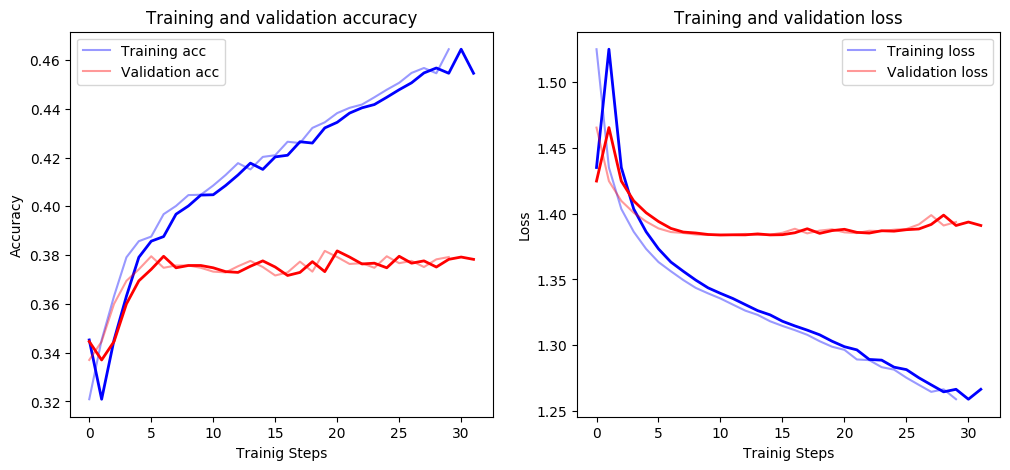

In [0]:
plot_history(history)

## Evaluando el modelo sobre los datos de evaluación para la competencia

Una vez que tenemos definido nuestro modelo, el último paso es ponerlo a prueba en los datos de evaluación para generar un archivo para enviar a la competencia Kaggle.

Comenzamos cargando el conjunto de datos.

In [0]:
test_dataset = pd.read_csv(os.path.join(DATA_DIRECTORY, 'test.csv'))
test_dataset.head()

### Creamos el conjunto de datos para darle al modelo entrenado

Tenemos que preprocesar los datos de evaluación de la misma manera que preprocesamos los de entrenamiento (para que sean compatibles con lo esperado por el modelo). Por suerte, es tan simple como hacer un par de modificaciones a lo ya hecho previamente. Lo único que tenemos que tener en cuenta es que ahora el conjunto de datos no generará una etiqueta.

In [0]:
# First tokenize the description

test_dataset["TokenizedDescription"] = test_dataset["Description"]\
    .fillna(value="").apply(tokenize_description)

test_dataset["AgeNormed"] = AgeScaler.transform(test_dataset["Age"].values.reshape(-1,1))
#test_dataset["FeeNormed"] = FeeScaler.transform(test_dataset["Fee"].values.reshape(-1,1))


# Generate the basic TF dataset

tf_test_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(test_dataset, True),
    output_types=instance_types  # It should have the same instance types
)

for data in tf_test_dataset.take(2):  # The dataset only returns a data instance now (no target)
    pprint(data)
    print()

### Padding batches

Por último, y previo a probar el modelo sobre los datos de evaluación, generamos el conjunto de datos "rellenado". 

A diferencia de los datos de entrenamiento y validación, en este caso no permutamos las instancias, pues necesitamos saber a que `PID` pertenece cada una.

Por otra parte, utilizamos los mismos valores de `padding_shapes` y `padding_values` para el primer componente (el de los datos), ignorando el valor del segundo componente (el de las etiquetas).

In [0]:
test_data = tf_test_dataset.padded_batch(
    128, 
    padded_shapes=padding_shapes[0], 
    padding_values=padding_values[0]
)

### Correr el modelo

El último paso es correr el modelo sobre los datos de evaluación para conseguir las predicciones a enviar a la competencia.

In [0]:
test_dataset["AdoptionSpeed"] = model.predict(test_data).argmax(axis=1)

test_dataset.to_csv("./submission.csv", index=False, columns=["PID", "AdoptionSpeed"])

In [0]:
#model.save("/content/drive/My Drive/AprendizajeProfundo/model_343.h5")